In [1]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns

project_root = "/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn"


# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

# Import the modules
from db_connectors.bigquery_service import BigqueryService
from data_gathering import data_gathering
from utils.logger import get_logger
from data_cleaning import data_cleaning
from feature_computation import feature_computation

logger = get_logger(__name__)

Changing working directory from /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src/eda to /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn
Adding /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src to sys.path


In [2]:
config = configparser.ConfigParser()
config.read("src/params.ini")

['src/params.ini']

In [3]:
train_from = config.get("PARAMS", "train_from")
train_to = config.get("PARAMS", "train_to")

# Load Logistic Regression parameters
logistic_regression_params = {
    "penalty": config.get("LOGISTIC_REGRESSION", "penalty", fallback="l2"),
    "C": config.getfloat("LOGISTIC_REGRESSION", "C", fallback=1.0),
    "solver": config.get("LOGISTIC_REGRESSION", "solver", fallback="saga"),
    "max_iter": config.getint("LOGISTIC_REGRESSION", "max_iter", fallback=10000),
}

# Load LightGBM parameters
lightgbm_params = {
    "boosting_type": config.get("LIGHTGBM", "boosting_type", fallback="gbdt"),
    "num_leaves": config.getint("LIGHTGBM", "num_leaves", fallback=31),
    "max_depth": config.getint("LIGHTGBM", "max_depth", fallback=-1),
    "learning_rate": config.getfloat("LIGHTGBM", "learning_rate", fallback=0.1),
    "n_estimators": config.getint("LIGHTGBM", "n_estimators", fallback=100),
}

In [4]:
query = """
WITH selectable_customer AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  RAND() < 0.25
)

SELECT 
    customer_id,
    MONTH,
    YEAR,
    NUM_DAYS_ACT,
    order_mobile_from_new_alta,
    service_mobile_pending_install,
    service_fix_pending_install,
    service_mobile_cancelled,
    service_fix_cancelled,
    service_mobile_pending_install_3month,
    service_fix_pending_install_3month,
    service_mobile_cancelled_3month,
    service_fix_cancelled_3month,
    service_mobile_pending_install_6month,
    service_fix_pending_install_6month,
    service_mobile_cancelled_6month,
    service_fix_cancelled_6month,
    pago_final_0,
    dif_pago_final_prev_month,
    dif_pago_final_prev_2_month,
    dif_pago_final_prev_3_month,
    periodica_0,
    dif_periodica_prev_month,
    dif_periodica_prev_2_month,
    dif_periodica_prev_3_month,
    consumo_0,
    dif_consumo_prev_month,
    dif_consumo_prev_2_month,
    dif_consumo_prev_3_month,
    aperiodica_0,
    dif_aperiodica_prev_month,
    dif_aperiodica_prev_2_month,
    dif_aperiodica_prev_3_month,
    discount_0,
    dif_discount_prev_month,
    dif_discount_prev_2_month,
    dif_discount_prev_3_month,
    ajuste_0,
    dif_ajuste_prev_month,
    dif_ajuste_prev_2_month,
    dif_ajuste_prev_3_month,
    Tota_Compra_disp,
    Curr_Compra_disp,
    Curr_Compra_Finanz_disp,
    Curr_Finanz_disp,
    Month_purchase_disp,
    Modelo_disp,
    Import_Rest_quota_disp,
    pvp_total_disp,
    pvp_total_disp_movil,
    Curr_cancel_disp,
    Tota_cancel_disp,
    MIN_DAYS_PERM_CURR,
    MIN_PENALTY_AMOUNT_CURR,
    PREV_FINISHED_PERM,
    NUM_GB_OWNN_CURR,
    NUM_GB_2G_CURR,
    NUM_GB_3G_CURR,
    NUM_GB_4G_CURR,
    NUM_GB_5G_CURR,
    NUM_SESS_CURR,
    NUM_SECS_CURR,
    NUM_CALL_CURR,
    NUM_CALL_WEEK_CURR,
    NUM_CALL_WEEKEND_CURR,
    NUM_SECS_WEEK_CURR,
    NUM_SECS_WEEKEND_CURR,
    NUM_CALL_WEEK,
    NUM_CALL_WEEKEND,
    NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

In [5]:
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 716237
INFO - Starting cleaning data
INFO - Completed cleaning data!
INFO -   customer_id MONTH  YEAR  dif_pago_final_prev_month  \
0      359543    12  2022                      -1.32   
1     4124818    12  2022                       0.07   
2      279557    12  2022                       0.00   
3      199882    12  2022                     -57.76   
4     1417539    09  2022                       3.99   

   dif_pago_final_prev_2_month  dif_pago_final_prev_3_month  \
0                        -0.60                         0.00   
1                        -4.53                        -9.12   
2                         0.30                        -0.30   
3                       -53.80                       -52.73   
4                         4.04                         5.00   

   dif_consumo_prev_month  dif_consumo_prev_2_month  dif_consumo_prev_3_month  \
0                    9.93                    -27.75    

In [40]:
features, target, features_test, target_test = feature_computation(
    clean_data, train_from, train_to, logger
)

INFO - Starting feature computation
INFO - Train computation from 2022-01-01 00:00:00 to 2022-06-01 00:00:00. Target for 2022-08-01 00:00:00
INFO - Test computation from 2022-02-01 00:00:00 to 2022-07-01 00:00:00. Target for 2022-09-01 00:00:00
INFO - Removing 23617 previous churned users from train set
INFO - Removing 26871 previous churned users from test set
INFO - Starting features and target computation
INFO - Features computed
INFO - Features: ['pago_final_0', 'consumo_0', 'aperiodica_0', 'discount_0', 'ajuste_0', 'NUM_GB_OWNN_CURR', 'NUM_GB_2G_CURR', 'NUM_GB_3G_CURR', 'NUM_GB_4G_CURR', 'NUM_GB_5G_CURR', 'NUM_SESS_CURR', 'NUM_SECS_CURR', 'NUM_CALL_CURR', 'NUM_CALL_WEEK_CURR', 'NUM_CALL_WEEKEND_CURR', 'NUM_SECS_WEEK_CURR', 'NUM_SECS_WEEKEND_CURR', 'NUM_CALL_WEEK', 'NUM_CALL_WEEKEND', 'NUM_DAYS_ACT', 'order_mobile_from_new_alta', 'MIN_DAYS_PERM_CURR', 'PREV_FINISHED_PERM', 'dif_pago_final_prev_month', 'dif_pago_final_prev_2_month', 'dif_pago_final_prev_3_month', 'dif_consumo_prev_m

In [41]:
def assess_NA(data: pd.DataFrame):
    """
    Returns a pd.DataFrame denoting the total number of NA
    values and the percentage of NA values in each column.
    """
    # pd.Datadenoting features and the sum of their null values
    nulls = data.isnull().sum().reset_index().rename(columns={0: "count"})
    nulls["percent"] = nulls["count"] * 100 / len(data)

    return nulls

In [42]:
null_clean = assess_NA(clean_data)

In [43]:
null_clean.sort_values(by=["count"], ascending=False).head(15)

,index,count,percent
0,customer_id,0,0.0
1,MONTH,0,0.0
26,MIN_DAYS_PERM_CURR,0,0.0
27,PREV_FINISHED_PERM,0,0.0
28,pago_final_0,0,0.0
29,consumo_0,0,0.0
30,aperiodica_0,0,0.0
31,discount_0,0,0.0
32,ajuste_0,0,0.0
33,NUM_GB_OWNN_CURR,0,0.0


In [44]:
(target == 1).sum()

1037

In [45]:
(target == 0).sum()

34604

In [10]:
def calculate_uplift(target, y_pred_proba):
    """
    Calculate the uplift for each decile.

    Args:
    - y_true (array-like): True labels.
    - y_pred_proba (array-like): Predicted probabilities.

    Returns:
    - pd.Series: Uplift for each decile.
    """
    data = pd.DataFrame({"y_true": target, "y_pred_proba": y_pred_proba})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    data_sorted["decile"] = pd.qcut(
        data_sorted["y_pred_proba"], q=10, labels=list(reversed(range(10)))
    )
    decile_churn_rate = data_sorted.groupby("decile", observed=True)["y_true"].mean()

    overall_churn_rate = data["y_true"].mean()
    uplift = decile_churn_rate / overall_churn_rate

    # return by ascending deciles
    return uplift.sort_index(ascending=False)

In [11]:
def evaluate_metrics_lgb(y_true, y_pred, n_trees, lr, train_or_test="test"):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    uplift = calculate_uplift(y_true, y_pred)

    print(uplift)

    print(
        f"Lightgbm model with {n_trees} n of trees and {lr} learning rate on {train_or_test}: Roc AUC {roc_auc:.4f} and PR AUC {pr_auc:.4f}"
    )

    print(
        f"Lightgbm model with {n_trees} n of trees and {lr} learning rate on {train_or_test}: {uplift[0]} Uplift on the first decile"
    )

In [48]:
n_trees = [100, 150, 200, 250, 300]
lr = [0.1, 0.05, 0.01]

In [49]:
for n in n_trees:
    for r in lr:
        pipeline = Pipeline(
            [
                (
                    "lightgbm",
                    lgb.LGBMClassifier(
                        boosting_type="gbdt",
                        max_depth=-1,
                        learning_rate=r,
                        n_estimators=n,
                        random_state=42,
                        verbose=-1,
                    ),
                ),
            ]
        )

        pipeline.fit(features, target)

        preds_train = pipeline.predict_proba(features)[:, 1]
        preds = pipeline.predict_proba(features_test)[:, 1]

        # evaluate_metrics_lgb(target, preds_train, n, r, "train")
        evaluate_metrics_lgb(target_test, preds, n, r, "test")

decile
0    1.562191
1    1.395112
2    1.152847
3    1.119431
4    1.027852
5    0.943998
6    0.760211
7    0.827042
8    0.768565
9    0.442760
Name: y_true, dtype: float64
Lightgbm model with 100 n of trees and 0.1 learning rate on test: Roc AUC 0.5904 and PR AUC 0.0516
Lightgbm model with 100 n of trees and 0.1 learning rate on test: 1.5621911265311381 Uplift on the first decile
decile
0    1.687501
1    1.403466
2    1.136139
3    1.086015
4    0.977713
5    1.035891
6    0.793627
7    0.718441
8    0.735149
9    0.426052
Name: y_true, dtype: float64
Lightgbm model with 100 n of trees and 0.05 learning rate on test: Roc AUC 0.6004 and PR AUC 0.0543
Lightgbm model with 100 n of trees and 0.05 learning rate on test: 1.6875005751833685 Uplift on the first decile
decile
0    1.720916
1    1.453590
2    1.129859
3    1.202603
4    1.076673
5    0.793384
6    0.785273
7    0.852887
8    0.609883
9    0.378720
Name: y_true, dtype: float64
Lightgbm model with 100 n of trees and 0.01 lear

In [50]:
best_model_lr = 0.01
best_model_n_trees = 150
pipeline = Pipeline(
    [
        (
            "lightgbm",
            lgb.LGBMClassifier(
                boosting_type="gbdt",
                max_depth=-1,
                learning_rate=best_model_lr,
                n_estimators=best_model_n_trees,
                random_state=42,
                verbose=-1,
            ),
        ),
    ]
)

pipeline.fit(features, target)

preds_train = pipeline.predict_proba(features)[:, 1]
preds = pipeline.predict_proba(features_test)[:, 1]
preds_test = pipeline.predict(features_test)

evaluate_metrics_lgb(target, preds_train, best_model_n_trees, best_model_lr, "train")
evaluate_metrics_lgb(target_test, preds, best_model_n_trees, best_model_lr, "test")

decile
0    6.335761
1    1.301869
2    0.771478
3    0.405253
4    0.385523
5    0.376095
6    0.154296
7    0.154296
8    0.086816
9    0.028914
Name: y_true, dtype: float64
Lightgbm model with 150 n of trees and 0.01 learning rate on train: Roc AUC 0.8755 and PR AUC 0.4006
Lightgbm model with 150 n of trees and 0.01 learning rate on train: 6.335761179782395 Uplift on the first decile
decile
0    1.695855
1    1.478651
2    1.303218
3    0.953227
4    1.160491
5    0.860458
6    0.701733
7    0.852365
8    0.618004
9    0.375928
Name: y_true, dtype: float64
Lightgbm model with 150 n of trees and 0.01 learning rate on test: Roc AUC 0.6106 and PR AUC 0.0558
Lightgbm model with 150 n of trees and 0.01 learning rate on test: 1.6958545384268506 Uplift on the first decile


In [25]:
data = pd.DataFrame({"y_true": target_test, "y_pred_proba": preds, "y_pred": preds_test})
data_sorted = data.sort_values(by="y_true", ascending=False)

In [145]:
feature_names = features.columns
# Extract coefficients
lr_model = pipeline.named_steps["lightgbm"]
coefficients = lr_model.feature_importances_  # for Logistic Regression

# Create a DataFrame for easy visualization
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)

In [146]:
cols_no_importance = feature_importance[feature_importance["Coefficient"] < 30]["Feature"]

<Axes: xlabel='Coefficient', ylabel='Feature'>

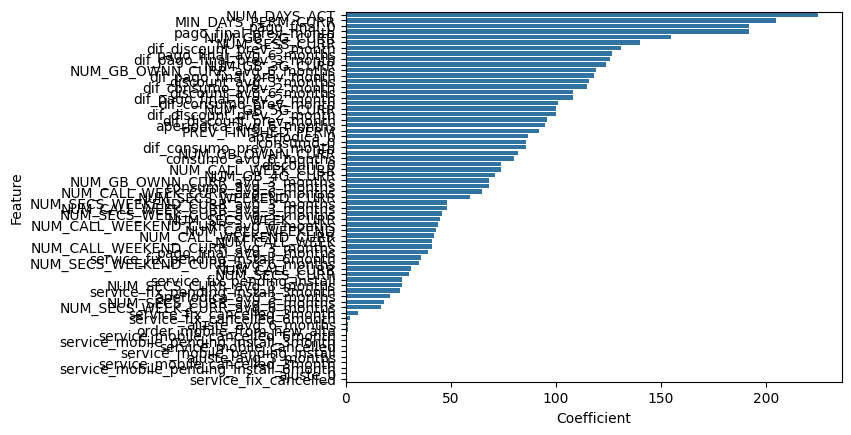

In [147]:
order_columns = feature_importance.sort_values("Coefficient", ascending=False)[
    "Feature"
]
sns.barplot(
    feature_importance,
    x="Coefficient",
    y="Feature",
    order=order_columns,
)

In [152]:
features_dropped = features.drop(columns=cols_no_importance)
features_dropped_test = features_test.drop(columns=cols_no_importance)

In [153]:
features_dropped

,pago_final_0,consumo_0,aperiodica_0,discount_0,NUM_GB_OWNN_CURR,NUM_GB_2G_CURR,NUM_GB_3G_CURR,NUM_GB_4G_CURR,NUM_GB_5G_CURR,NUM_SESS_CURR,...,discount_avg_6_months,NUM_GB_OWNN_CURR_avg_3_months,NUM_GB_OWNN_CURR_avg_6_months,NUM_CALL_WEEK_CURR_avg_3_months,NUM_CALL_WEEK_CURR_avg_6_months,NUM_CALL_WEEKEND_CURR_avg_3_months,NUM_CALL_WEEKEND_CURR_avg_6_months,NUM_SECS_WEEK_CURR_avg_3_months,NUM_SECS_WEEKEND_CURR_avg_3_months,NUM_SECS_WEEKEND_CURR_avg_6_months
0,55.0292,110.1659,0.0,-191.7339,0.031088,0.000096,0.011931,4.133809,0.000000,1954,...,-165.862500,0.185588,0.195415,152.000000,120.500000,37.333333,26.333333,30289.666667,8900.000000,5586.500000
1,85.0900,7.8844,120.0,-156.0896,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,-51.789683,0.000000,0.000000,15.000000,12.833333,1.333333,2.833333,764.666667,6.666667,86.333333
2,67.8450,376.4855,0.0,-457.0280,4.333472,0.000539,0.204715,7.033735,8.274004,26972,...,-366.458383,6.438764,6.748296,327.000000,263.333333,128.000000,115.333333,52375.333333,17220.333333,16678.000000
3,50.9000,223.8407,120.0,-419.6658,1.849722,0.000366,0.108648,22.732534,0.000000,8232,...,-257.401883,3.739307,3.968482,263.666667,249.000000,56.000000,57.166667,37379.333333,7876.000000,9317.166667
4,55.8141,100.6445,0.0,-178.7333,2.864490,0.000440,0.084532,44.816553,0.454133,8060,...,-168.873950,7.038711,5.319472,147.333333,143.500000,30.000000,27.000000,17026.333333,6618.333333,5485.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47629,70.2885,343.8690,165.0,-607.1275,6.262426,0.000000,0.018946,7.890733,0.168042,5424,...,-451.316433,6.287275,6.783493,265.000000,267.000000,26.000000,25.500000,43875.333333,2777.666667,2742.166667
47630,30.3000,12.1267,0.0,-40.0349,0.493641,0.000046,0.018045,1.302436,0.000000,3082,...,-52.518833,0.622566,0.616213,18.333333,25.333333,10.666667,12.000000,2199.000000,1255.333333,1431.500000
47631,115.9758,544.6884,0.0,-641.1017,15.880268,0.008036,1.420019,67.363741,0.000000,28610,...,-617.292100,7.577509,6.416394,675.333333,683.666667,177.666667,184.333333,87544.333333,20386.333333,20566.833333
47632,116.1201,424.2206,0.0,-509.4223,21.188541,0.012646,0.850269,51.251579,0.000000,28121,...,-391.108983,16.194390,13.489955,508.333333,405.333333,149.666667,127.833333,69688.333333,19579.000000,17083.333333


In [52]:
best_model_lr = 0.01
best_model_n_trees = 150
pipeline = Pipeline(
    [
        (
            "lightgbm",
            lgb.LGBMClassifier(
                boosting_type="gbdt",
                max_depth=-1,
                learning_rate=best_model_lr,
                n_estimators=best_model_n_trees,
                random_state=42,
                verbose=-1,
            ),
        ),
    ]
)

pipeline.fit(features_dropped, target)

preds_train = pipeline.predict_proba(features_dropped)[:, 1]
preds = pipeline.predict_proba(features_dropped_test)[:, 1]

evaluate_metrics_lgb(target, preds_train, best_model_n_trees, best_model_lr, "train")
evaluate_metrics_lgb(target_test, preds, best_model_n_trees, best_model_lr, "test")

NameError: name 'features_dropped' is not defined

In [158]:
feature_names = features_dropped.columns
# Extract coefficients
lr_model = pipeline.named_steps["lightgbm"]
coefficients = lr_model.feature_importances_  # for Logistic Regression

# Create a DataFrame for easy visualization
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)

<Axes: xlabel='Coefficient', ylabel='Feature'>

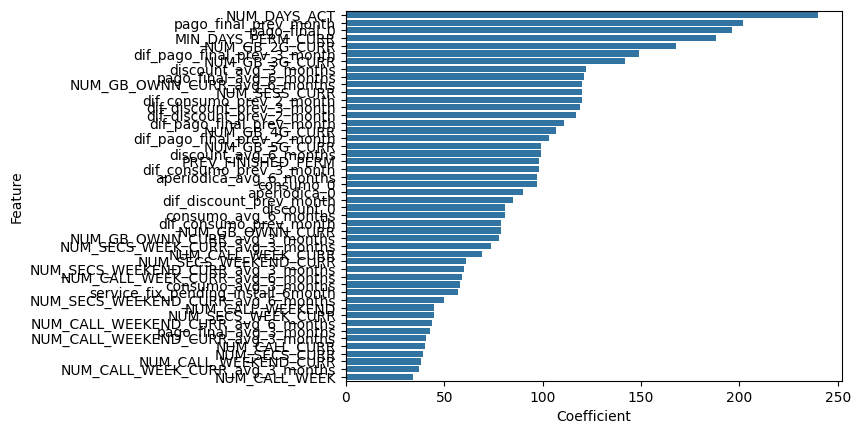

In [159]:
order_columns = feature_importance.sort_values("Coefficient", ascending=False)[
    "Feature"
]
sns.barplot(
    feature_importance,
    x="Coefficient",
    y="Feature",
    order=order_columns,
)

Let's see what results we where getting with LogisticRegression model

In [51]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "logistic_regression",
            LogisticRegression(
                penalty=logistic_regression_params["penalty"],
                C=logistic_regression_params["C"],
                solver=logistic_regression_params["solver"],
                max_iter=logistic_regression_params["max_iter"],
                random_state=42,
            ),
        ),
    ]
)

pipeline.fit(features, target)
preds_train = pipeline.predict_proba(features)[:, 1]
preds_test = pipeline.predict_proba(features_test)[:, 1]

evaluate_metrics_lgb(target, preds_train, 0, 0, "train")
evaluate_metrics_lgb(target_test, preds_test, 0, 0, "test")

decile
0    2.536233
1    1.369373
2    1.292225
3    1.060782
4    0.993278
5    0.916130
6    0.646113
7    0.405026
8    0.453243
9    0.327786
Name: y_true, dtype: float64
Lightgbm model with 0 n of trees and 0 learning rate on train: Roc AUC 0.6692 and PR AUC 0.0875
Lightgbm model with 0 n of trees and 0 learning rate on train: 2.536233166336027 Uplift on the first decile
decile
0    1.745978
1    1.578899
2    1.060953
3    1.186263
4    0.802226
5    0.877166
6    0.827042
7    0.501238
8    0.685025
9    0.735149
Name: y_true, dtype: float64
Lightgbm model with 0 n of trees and 0 learning rate on test: Roc AUC 0.6023 and PR AUC 0.0577
Lightgbm model with 0 n of trees and 0 learning rate on test: 1.7459783178877426 Uplift on the first decile


In [66]:
from sklearn.model_selection import GridSearchCV

In [153]:
param_grid = {
    "lightgbm__learning_rate": [1, 0.5, 0.25, 0.01],
    "lightgbm__n_estimators": [70, 100, 150, 200, 250],
}
grid_params = {
    "learning_rate": [0.005, 0.01],
    "n_estimators": [70, 100, 150],
    "num_leaves": [
        6,
        8,
        12,
        16,
    ],  # large num_leaves helps improve accuracy but might lead to over-fitting
    # "boosting_type": ["gbdt", "dart"],  # for better accuracy -> try dart
    "objective": ["binary"],
    # "max_bin": [
    #     255,
    #     510,
    # ],  # large max_bin helps improve accuracy but might slow down training progress
    "random_state": [500],
    "colsample_bytree": [0.64, 0.65, 0.66],
    "subsample": [0.7, 0.75],
    "reg_alpha": [0, 1, 1.2],
    "reg_lambda": [0, 1, 1.2, 1.4],
}

In [154]:
def custom_scorer(estimator, X, y):
    # Calculate validation score (F1 score)
    y_pred = estimator.predict_proba(X)[:, 1]
    data = pd.DataFrame({"y_true": y, "y_pred_proba": y_pred})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    decile_cutoff = int(len(data_sorted) * 0.1)
    first_decile = data_sorted.head(decile_cutoff)
    true_positives = first_decile["y_true"].sum()
    return true_positives / decile_cutoff

In [155]:
import itertools

In [156]:
keys, values = zip(*grid_params.items())

permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [157]:
for i in permutations_dicts:
    print(i)
    break

{'learning_rate': 0.005, 'n_estimators': 70, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'colsample_bytree': 0.64, 'subsample': 0.7, 'reg_alpha': 0, 'reg_lambda': 0}


In [14]:
def accuracy_first_decile(target, preds):
    # Calculate validation score (F1 score)
    data = pd.DataFrame({"y_true": target, "y_pred_proba": preds})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    decile_cutoff = int(len(data_sorted) * 0.1)
    first_decile = data_sorted.head(decile_cutoff)
    true_positives = first_decile["y_true"].sum()
    return true_positives / decile_cutoff, data

In [159]:
def own_grid_search(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    paramgrid: dict[str, list[int]],
    custom_scorer,
    model: str = "lightgbm",
):
    best_accuracy = 0
    best_accuracy_params = {}

    keys, values = zip(*paramgrid.items())

    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    for params in permutations_dicts:
        logger.info(f"Training model with params {params}")
        pipeline = Pipeline(
            [
                (
                    "lightgbm",
                    lgb.LGBMClassifier(
                        learning_rate=params["learning_rate"],
                        n_estimators=params["n_estimators"],
                        num_leaves=params["num_leaves"],
                        colsample_bytree=params["colsample_bytree"],
                        subsample=params["subsample"],
                        reg_alpha=params["reg_alpha"],
                        reg_lambda=params["reg_lambda"],
                        random_state=42,
                        verbose=-1,
                    ),
                ),
            ]
        )

        pipeline.fit(X_train, y_train)

        preds = pipeline.predict_proba(X_test)[:, 1]

        accuracy = custom_scorer(y_test, preds)

        logger.info(f"Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_accuracy_params = params

    return best_accuracy, best_accuracy_params

In [160]:
best_accuracy, best_accuracy_params = own_grid_search(
    features, target, features_test, target_test, grid_params, accuracy_first_decile
)

INFO - Training model with params {'learning_rate': 0.005, 'n_estimators': 70, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'colsample_bytree': 0.64, 'subsample': 0.7, 'reg_alpha': 0, 'reg_lambda': 0}
INFO - Accuracy: 0.05999387817569636
INFO - Training model with params {'learning_rate': 0.005, 'n_estimators': 70, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'colsample_bytree': 0.64, 'subsample': 0.7, 'reg_alpha': 0, 'reg_lambda': 1}
INFO - Accuracy: 0.060299969390878484
INFO - Training model with params {'learning_rate': 0.005, 'n_estimators': 70, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'colsample_bytree': 0.64, 'subsample': 0.7, 'reg_alpha': 0, 'reg_lambda': 1.2}
INFO - Accuracy: 0.060299969390878484
INFO - Training model with params {'learning_rate': 0.005, 'n_estimators': 70, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'colsample_bytree': 0.64, 'subsample': 0.7, 'reg_alpha': 0, 'reg_lambda': 1.4}
INFO - Accuracy

In [161]:
best_accuracy

0.06917661463116008

In [162]:
best_accuracy_params

{'learning_rate': 0.005,
 'n_estimators': 100,
 'num_leaves': 12,
 'objective': 'binary',
 'random_state': 500,
 'colsample_bytree': 0.64,
 'subsample': 0.7,
 'reg_alpha': 0,
 'reg_lambda': 1}

In [196]:
pipeline = Pipeline(
    [
        (
            "lightgbm",
            lgb.LGBMClassifier(
                learning_rate=best_accuracy_params["learning_rate"],
                n_estimators=best_accuracy_params["n_estimators"],
                num_leaves=best_accuracy_params["num_leaves"],
                colsample_bytree=best_accuracy_params["colsample_bytree"],
                subsample=best_accuracy_params["subsample"],
                reg_alpha=best_accuracy_params["reg_alpha"],
                reg_lambda=best_accuracy_params["reg_lambda"],
                random_state=500,
                verbose=-1,
            ),
        ),
    ]
)

pipeline.fit(features, target)

preds_train = pipeline.predict_proba(features)[:, 1]
preds = pipeline.predict_proba(features_test)[:, 1]
preds_no = pipeline.predict(features_test)

evaluate_metrics_lgb(target, preds_train, best_model_n_trees, best_model_lr, "train")
evaluate_metrics_lgb(target_test, preds, best_model_n_trees, best_model_lr, "test")
acc, data= accuracy_first_decile(target_test, preds)
print(acc)

decile
0    3.707254
1    1.545992
2    1.196126
3    0.865000
4    0.745266
5    0.643764
6    0.491817
7    0.446860
8    0.247048
9    0.121512
Name: y_true, dtype: float64
Lightgbm model with 70 n of trees and 0.01 learning rate on train: Roc AUC 0.7449 and PR AUC 0.1350
Lightgbm model with 70 n of trees and 0.01 learning rate on train: 3.7072540712730113 Uplift on the first decile
decile
0    1.812810
1    1.395539
2    1.170271
3    1.176828
4    1.052922
5    0.857615
6    0.822622
7    0.745969
8    0.600373
9    0.382113
Name: y_true, dtype: float64
Lightgbm model with 70 n of trees and 0.01 learning rate on test: Roc AUC 0.6182 and PR AUC 0.0591
Lightgbm model with 70 n of trees and 0.01 learning rate on test: 1.8128100238355989 Uplift on the first decile
0.06642179369452096


In [171]:
data_sorted = data.sort_values(by="y_pred_proba", ascending=False)

In [172]:
data_sorted

,y_true,y_pred_proba
22027,0.0,0.169420
7108,1.0,0.167308
13144,0.0,0.166744
22430,0.0,0.166744
31307,0.0,0.166354
...,...,...
8033,0.0,0.021574
24847,0.0,0.021574
32301,0.0,0.021574
8042,0.0,0.021574


In [177]:
decile_cutoff = int(len(data_sorted) * 0.1)
first_decile = data_sorted.head(decile_cutoff)

In [183]:
data_sorted["y_true"].sum()

1197.0

In [182]:
print(first_decile["y_true"].sum(), len(first_decile["y_true"]))

217.0 3267


In [188]:
data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
data_sorted["decile"] = pd.qcut(
    data_sorted["y_pred_proba"], q=10, labels=list(reversed(range(10)))
)
decile_churn_rate = data_sorted.groupby("decile", observed=True)["y_true"].sum()

<Axes: xlabel='decile'>

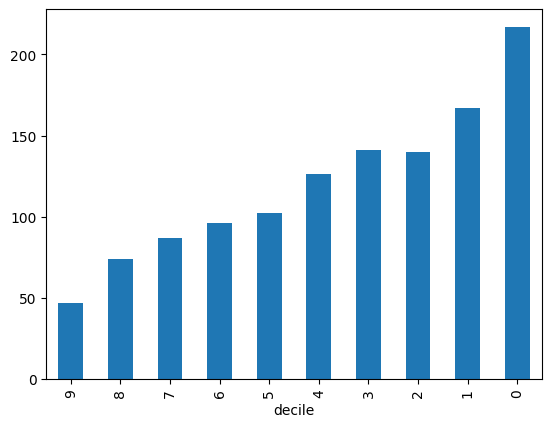

In [190]:
decile_churn_rate.plot(kind="bar")

In [ ]:
best_model_lr = 0.01
best_model_n_trees = 150
pipeline = Pipeline(
    [
        (
            "lightgbm",
            lgb.LGBMClassifier(
                random_state=42,
                verbose=-1,
            ),
        ),
    ]
)

search = GridSearchCV(pipeline, grid_params, n_jobs=-1, scoring=custom_scorer)

search.fit(features, target)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [175]:
best_model_lr = 0.01
best_model_n_trees = 70
pipeline = Pipeline(
    [
        (
            "lightgbm",
            lgb.LGBMClassifier(
                boosting_type="gbdt",
                max_depth=-1,
                learning_rate=best_model_lr,
                n_estimators=best_model_n_trees,
                random_state=42,
                verbose=-1,
            ),
        ),
    ]
)

pipeline.fit(features, target)

preds_train = pipeline.predict_proba(features)[:, 1]
preds = pipeline.predict_proba(features_test)[:, 1]
preds_test = pipeline.predict(features_test)

evaluate_metrics_lgb(target, preds_train, best_model_n_trees, best_model_lr, "train")
evaluate_metrics_lgb(target_test, preds, best_model_n_trees, best_model_lr, "test")
print(custom_scorer(pipeline, features_test, target_test))

decile
0    5.342484
1    1.224721
2    0.853250
3    0.678925
4    0.486067
5    0.452355
6    0.350813
7    0.244977
8    0.302665
9    0.126606
Name: y_true, dtype: float64
Lightgbm model with 70 n of trees and 0.01 learning rate on train: Roc AUC 0.8116 and PR AUC 0.2907
Lightgbm model with 70 n of trees and 0.01 learning rate on train: 5.342483551901745 Uplift on the first decile
decile
0    1.704209
1    1.479104
2    1.202603
3    1.161912
4    1.010830
5    0.814694
6    0.870934
7    0.660957
8    0.643748
9    0.484929
Name: y_true, dtype: float64
Lightgbm model with 70 n of trees and 0.01 learning rate on test: Roc AUC 0.6102 and PR AUC 0.0563
Lightgbm model with 70 n of trees and 0.01 learning rate on test: 1.7042085016703326 Uplift on the first decile
0.06244260789715335


In [176]:
preds_test.sum()

0.0

Let's test without dropping the churned users in the train months + drop month

In [6]:
features, target, features_test, target_test = feature_computation(
    clean_data, train_from, train_to, logger, keep_gap_month_churns=True
)

INFO - Starting feature computation
INFO - Train computation from 2022-01-01 00:00:00 to 2022-06-01 00:00:00. Target for 2022-08-01 00:00:00
INFO - Test computation from 2022-02-01 00:00:00 to 2022-07-01 00:00:00. Target for 2022-09-01 00:00:00
INFO - Removing 23428 previous churned users from train set
INFO - Removing 26672 previous churned users from test set
INFO - Unique customers in train: 38325
INFO - Unique customers in test: 35213
INFO - Starting features and target computation
INFO - Length train data: 36477
INFO - Length test data: 33520
INFO - Features computed
INFO - Features: ['pago_final_0', 'consumo_0', 'aperiodica_0', 'discount_0', 'ajuste_0', 'NUM_GB_OWNN_CURR', 'NUM_GB_2G_CURR', 'NUM_GB_3G_CURR', 'NUM_GB_4G_CURR', 'NUM_GB_5G_CURR', 'NUM_SESS_CURR', 'NUM_SECS_CURR', 'NUM_CALL_CURR', 'NUM_CALL_WEEK_CURR', 'NUM_CALL_WEEKEND_CURR', 'NUM_SECS_WEEK_CURR', 'NUM_SECS_WEEKEND_CURR', 'NUM_CALL_WEEK', 'NUM_CALL_WEEKEND', 'NUM_DAYS_ACT', 'order_mobile_from_new_alta', 'MIN_DAYS_PE

In [8]:
best_accuracy_params = {
    "learning_rate": 0.005,
    "n_estimators": 100,
    "num_leaves": 12,
    "objective": "binary",
    "random_state": 500,
    "colsample_bytree": 0.64,
    "subsample": 0.7,
    "reg_alpha": 0,
    "reg_lambda": 1,
}

In [15]:
pipeline = Pipeline(
    [
        (
            "lightgbm",
            lgb.LGBMClassifier(
                learning_rate=best_accuracy_params["learning_rate"],
                n_estimators=best_accuracy_params["n_estimators"],
                num_leaves=best_accuracy_params["num_leaves"],
                colsample_bytree=best_accuracy_params["colsample_bytree"],
                subsample=best_accuracy_params["subsample"],
                reg_alpha=best_accuracy_params["reg_alpha"],
                reg_lambda=best_accuracy_params["reg_lambda"],
                random_state=500,
                verbose=-1,
            ),
        ),
    ]
)

pipeline.fit(features, target)

preds_train = pipeline.predict_proba(features)[:, 1]
preds = pipeline.predict_proba(features_test)[:, 1]
preds_no = pipeline.predict(features_test)

evaluate_metrics_lgb(target, preds_train, best_accuracy_params["n_estimators"], best_accuracy_params["learning_rate"], "train")
evaluate_metrics_lgb(target_test, preds, best_accuracy_params["n_estimators"], best_accuracy_params["learning_rate"], "test")
acc, data = accuracy_first_decile(target_test, preds)
print(acc)

decile
0    3.465998
1    1.538333
2    1.120826
3    1.058075
4    0.903569
5    0.606220
6    0.466263
7    0.454943
8    0.265959
9    0.123412
Name: y_true, dtype: float64
Lightgbm model with 100 n of trees and 0.005 learning rate on train: Roc AUC 0.7362 and PR AUC 0.1380
Lightgbm model with 100 n of trees and 0.005 learning rate on train: 3.4659977818213874 Uplift on the first decile
decile
0    1.761269
1    1.485810
2    1.078755
3    1.083173
4    1.002885
5    0.975446
6    0.966374
7    0.820906
8    0.510264
9    0.319636
Name: y_true, dtype: float64
Lightgbm model with 100 n of trees and 0.005 learning rate on test: Roc AUC 0.6143 and PR AUC 0.0555
Lightgbm model with 100 n of trees and 0.005 learning rate on test: 1.7612687813021703 Uplift on the first decile
0.06392002423508028


In [22]:
type(pipeline["lightgbm"]).__name__

'LGBMClassifier'